In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

import os
from tqdm import tqdm
import numpy as np

from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Data parameter
batch_size=128

# Network's initial architecture
num_inputs = 28*28
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

In [4]:
path = os.path.dirname(os.path.abspath("__file__"))

data_path = path + "\\data"

## Load MNIST data

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

def get_MNIST_loaders(path, class_names, batch_size) :

    # load MNIST 
    mnist_train = datasets.MNIST(root=path, train=True, download=False, transform=transform)
    mnist_test = datasets.MNIST(root=path, train=False, download=False, transform=transform)


    # create a mask to filter indices for each label
    train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
    test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

    # Create Subset datasets for train, validation, and test
    train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
    test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

    # split train into train & validation
    train_size = int(0.7 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader

In [6]:
train_loader, val_loader, test_loader = get_MNIST_loaders(data_path, [i for i in range(10)], batch_size)

## Define model

In [7]:
class ANN (nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        
        self.fc1 = nn.Linear(num_inputs,num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, num_outputs)
        
        self.activation = torch.sigmoid ## nn.ReLU()
        
    def forward(self, x) :
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        
        return x
    
    def add_neurons (self, layer_name, fc1_weight_grad, fc1_bias_grad, fc2_weight_grad, num_neurons, device) :
        if layer_name == "fc1" :
            self.fc1, self.fc2 = add_neurons(self.fc1, self.fc2, 
                                             fc1_weight_grad, fc1_bias_grad, fc2_weight_grad,
                                             num_neurons, device)
        
        elif layer_name == "fc2" :
            self.fc2, self.fc3 = add_neurons(self.fc2, self.fc3, 
                                             fc1_weight_grad, fc1_bias_grad, fc2_weight_grad,
                                             num_neurons, device)

In [8]:
def add_neurons (fc1, fc2, fc1_weight_grad, fc1_bias_grad, fc2_weight_grad, num_neurons, device) :
    # PRE-LAYER
    num_in_1, num_out_1 = fc1.in_features, fc1.out_features
    new_fc1 = nn.Linear(in_features=num_in_1, out_features=num_out_1 + num_neurons).to(device)

    # Set parameters
    new_fc1.weight = nn.Parameter(torch.cat((fc1.weight,torch.randn(num_neurons, num_in_1).to(device))))
    new_fc1.bias = nn.Parameter(torch.cat((fc1.bias, torch.randn(num_neurons).to(device))))

    # Set gradients
    new_fc1.weight.grad = nn.Parameter(torch.cat((fc1_weight_grad,torch.randn(num_neurons, num_in_1).to(device)), dim=0))
    new_fc1.bias.grad = nn.Parameter(torch.cat((fc1_bias_grad, torch.randn(num_neurons).to(device)), dim=0))

    # POST-LAYER
    num_in_2, num_out_2 = fc2.in_features, fc2.out_features
    new_fc2 = nn.Linear(in_features=num_in_2 + num_neurons, out_features=num_out_2).to(device)
    
    # Set parameters
    new_fc2.weight = nn.Parameter(torch.cat((fc2.weight, torch.randn(num_out_2,num_neurons).to(device)), dim=1))
    new_fc2.bias = fc2.bias

    # Set gradients
    new_fc2.weight.grad = torch.cat((fc2_weight_grad, torch.randn(num_out_2, num_neurons).to(device)), dim=1)
    new_fc2.bias.grad = fc2.bias.grad

    return new_fc1, new_fc2

## Training pipeline

In [9]:
def count_all_parameters(model) :
    num_params = 0
    for param_name, param in model.named_parameters():
        num_param = torch.numel(param)
        print(param_name, ":", num_param)
        num_params += num_param
    return num_params

In [10]:
def get_batch_accuracy(model, data, targets, batch_size):
    output = model(data.view(batch_size, -1))
    idx = output.argmax(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    return round(acc*100,2)

In [11]:
def compute_loss(model, data, targets, loss, loss_name, batch_size) :
    if loss_name == "CE":
        y = model(data.view(batch_size, -1))
        loss_val = loss(y, targets)
    else :
        y = model(data.view(batch_size, -1))
        one_hot_targets = nn.functional.one_hot(targets, num_classes=10).to(y.dtype)
        loss_val = loss(y, one_hot_targets)
    return y, loss_val

In [12]:
def compute_val (model, loss, loss_name, val_loader, val_loss_hist, val_acc_hist, epoch, batch_size, device, print_shit=False) :
    model.eval()
    val_data, val_targets = next(iter(val_loader))
    val_data = val_data.to(device)
    val_targets = val_targets.to(device)
    
    # Forward path
    y, val_loss_val = compute_loss(model, val_data, val_targets, loss, loss_name, batch_size)
    val_loss_hist.append(val_loss_val.item())
    
    # ACCURACY
    if print_shit :
        print(f"Epoch {epoch}")
        # print(f"Train Set Loss: {train_loss_hist[epoch]:.2f}")
        print(f"Val Set Loss: {val_loss_hist[epoch]:.2f}")
        print("\n")
    val_acc_hist.append(get_batch_accuracy(model, val_data, val_targets, batch_size))
    
    
    return val_loss_hist, val_acc_hist

GradMax offers a way to initialize the added neurons :
- $W_l^{new}$ set to $0$ (cf hypothesis between eq (8) and (9)) ♠
- $\frac{\partial L}{\partial W_{l}^{new}}$ set to $W_{l+1}^{new,T} \mathbb{E}_D\left[\frac{\partial L}{\partial z_{l+1}}h_{l-1}^T\right]$ even though (9) suggests $W_{l+1}^{new,T} \frac{\partial L}{\partial z_{l+1}}h_{l-1}^T$ ♠
- $B_l^{new}$ set to 0 (not mentioned in the paper, "zeros or ones" according to layers.py file in the code) ♠
- $\frac{\partial L}{\partial B_{l}^{new}}$ set to 0 (not mentioned in the paper) ♠
- $W_{l+1}^{new}$ set as the top $k$ left-singular vectors of the matrix $\mathbb{E}_D\left[\frac{\partial L}{\partial z_{l+1}}h_{l-1}^T\right]$ and scaling them by $\frac{c}{||(\sigma_1,...,\sigma_k)||}$ (where $\sigma_i$
is the $i$-th largest singular value) ♠
- $\frac{\partial L}{\partial W_{l+1}^{new}}$ set to $0$ (eq (10)) ♠

On veut calculer $\mathbb{E}_D\left[\frac{\partial L}{\partial z_{l+1}}h_{l-1}^T\right]$.
Détail :
- $\frac{\partial L}{\partial z_{l+1}}$ : $[10,1]$ ou $[num_{hidden},1]$ (c'est le gradient calculé dans le layer suivant)
- $h_{l-1}^T$ : $[1,784]$ (c'est simplement l'input x)
Donc en fait, on veut juste la 

On sait calculer obtenir ces deux quantités, il suffit de faire la moyenne sur les données vue depuis le dernier ajout d'un neurone (tout le training set si on ajoute des neurones à la fin de chaque epoch, ou tout le batch si on ajoute des neurones à la fin de batchs)

Impémentation :
- On a besoin de savoir pendant quel layer on veut grow dans la training loop, pour savoir quel gradient on doit stocker.

In [13]:
def register_hooks(model, pre_layer, post_layer):
    activation = []
    grad = []

    def forward_hook(module, x, y):
        activation.append(y)
    def backward_hook(module, grad_input, grad_output) :
        grad.append(grad_output)
    
    forward_hook_handle = None
    if pre_layer :
        forward_hook_handle = pre_layer.register_forward_hook(forward_hook)
        
    backward_hook_handle = post_layer.register_full_backward_hook(backward_hook)

    return activation, grad, forward_hook_handle, backward_hook_handle

In [14]:
def train (model, growth_schedule, loss, loss_name, optimizer, train_loader, val_loader, 
           num_epochs, batch_size, device, c = 1, print_num_params = False) :
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    batch_index = 0
    if growth_schedule :
        growth_schedule = iter(growth_schedule)
    
    # Epoch training loop
    for epoch in tqdm(range(num_epochs)):
        
        # Initialize epoch
        train_batch = iter(train_loader)
        loss_epoch = 0
        
        # Batch training loop
        for i, (data, targets) in enumerate(train_batch):
            if i == 300 :
                break
            # Get data from the batch
            data = data.to(device)
            targets = targets.to(device)
            
            
            # Initialize GradMax growth
            if (growth_schedule is not None) and (batch_index%50 == 0) and (batch_index != 0):
                
                # Print the number of parameters
                if print_num_params :
                    count_all_parameters(model)
                
                # Remove previous hooks in case they are some
                for h in hooks_list :
                    h.remove()
                
                # Get the layer to grow and the number of neurons to add
                layer_name, num_neurons = next(growth_schedule)
                
                # Initialize the matrix on which we will perform SVD
                if layer_name == "fc1" :
                    matrix_to_SVD = torch.zeros(model.fc2.out_features, model.fc1.in_features).to(device)
                elif layer_name == "fc2" :
                    matrix_to_SVD = torch.zeros(model.fc3.out_features, model.fc2.in_features).to(device)
                    #print("matrix_to_SVD :", matrix_to_SVD.shape)

            model.train()
            
            # Get the gradient of the layer after the one we grow, for GradMax computation
            if (growth_schedule is not None) and (batch_index > 49): #and (batch_index%50 == 0) :
                if layer_name == "fc1" :
                    
                    h = data.view(batch_size, -1)
                    # register hooks
                    _, grad, _, backward_hook_handle = register_hooks(model, None, model.fc2)
                    hooks_list.append(backward_hook_handle)
                    
                    # Forward path
                    y, loss_val = compute_loss(model, data, targets, loss, loss_name, batch_size)
                    
                    # Gradient calculation + weight update
                    #output_grad = torch.zeros(torch.Size([])).requires_grad_(True).to(device)
                    optimizer.zero_grad()
                    loss_val.backward() # Pass output_grad
                    optimizer.step()
                    
                    # Compute the matrix to which we will apply SVD
                    #matrix_to_SVD += torch.mm(grad[0][0].t(),h) / batch_size
                    
                elif layer_name == "fc2" :
                    # register hooks
                    h, grad, forward_hook_handle, backward_hook_handle = register_hooks(model, model.fc1, model.fc3)
                    hooks_list.append(forward_hook_handle)
                    hooks_list.append(backward_hook_handle)
                    
                    # Forward path
                    y, loss_val = compute_loss(model, data, targets, loss, loss_name, batch_size)
                    
                    # Gradient calculation + weight update
                    #output_grad = torch.ones(torch.Size([])).requires_grad_(True)
                    optimizer.zero_grad()
                    loss_val.backward() # Pass output_grad
                    optimizer.step()
                    
                    # Compute the matrix to which we will apply SVD
                    #matrix_to_SVD += torch.mm(grad[0][0].t(),h[0]) / batch_size
            
            else :
                # Forward path
                y, loss_val = compute_loss(model, data, targets, loss, loss_name, batch_size)
                
                # Gradient calculation + weight update
                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()
            
            loss_epoch += loss_val.item()
            
            
            # Add neurons
            if (growth_schedule is not None) and (batch_index%50 == 0) and (batch_index != 0):
                #with torch.no_grad():
                    # Solve optimization problem (11)
                    #print("Shape of matrix_to_SVD :", matrix_to_SVD.shape)
                    # matrix_to_SVD = matrix_to_SVD.t()

                    #if layer_name == "fc1" :
                    #    model.fc1, model.fc2 = add_neurons(model.fc1, model.fc2, num_neurons, matrix_to_SVD, c, device)
                    #elif layer_name == "fc2" :
                    #    model.fc2, model.fc3 = add_neurons(model.fc2, model.fc3, num_neurons, matrix_to_SVD, c, device)
                    
                    if layer_name == "fc1" :
                        fc1_weight_grad = model.fc1.weight.grad
                        fc1_bias_grad = model.fc1.bias.grad
                        fc2_weight_grad = model.fc2.weight.grad
                        model.add_neurons(layer_name, fc1_weight_grad, fc1_bias_grad, fc2_weight_grad, num_neurons, device)
                    elif layer_name == "fc2" :
                        fc2_weight_grad = model.fc2.weight.grad
                        fc2_bias_grad = model.fc2.bias.grad
                        fc3_weight_grad = model.fc3.weight.grad
                        model.add_neurons(layer_name, fc2_weight_grad, fc2_bias_grad, fc3_weight_grad, num_neurons, device)
                    
                    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
            
            # Get feedback from train and val sets
            if batch_index%50 == 49:
                with torch.no_grad():
                    # Train data
                    train_loss_hist.append(loss_epoch/len(train_loader))
                    train_acc_hist.append(get_batch_accuracy(model, data, targets, batch_size))
                    
                    # Val data
                    val_loss_hist, val_acc_hist = compute_val (model,
                                                               loss,
                                                               loss_name,
                                                               val_loader, 
                                                               val_loss_hist, 
                                                               val_acc_hist,
                                                               epoch,
                                                               batch_size,
                                                               device,
                                                               print_shit=False)
                    
            # End of batch training loop  
            batch_index += 1

            if batch_index%50 == 0:
                print(f'{i} batches used in epoch {epoch}')

        print("Total number of batches :", batch_index)
    output = [train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist]
    return output

In [15]:
def test (model, loader, device) :
    batches = iter(loader)
    num_batches = len(batches)
    acc_sum = 0
    for (data, targets) in batches :
        acc_sum += get_batch_accuracy(model, data.to(device), targets.to(device), batch_size)
    return acc_sum/num_batches

## Train the root & target models for comparisons

In [16]:
loss = nn.MSELoss() # nn.CrossEntropyLoss()
loss_name = "MSE" # "CE"
num_epochs = 3
growth_schedule = None
hooks_list= []

In [17]:
root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
optimizer = torch.optim.Adam(root_model.parameters(), lr=5e-3, maximize=False)
output = train(root_model, growth_schedule, loss, loss_name, optimizer, train_loader, val_loader, num_epochs, batch_size, device)
test_acc_root = test(root_model, test_loader, device)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:05<00:11,  5.66s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:15<00:07,  7.84s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.18s/it]

299 batches used in epoch 2
Total number of batches : 900


In [18]:
target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
optimizer = torch.optim.Adam(target_model.parameters(), lr=5e-3, maximize=False)
output = train(target_model, growth_schedule, loss, loss_name, optimizer, train_loader, val_loader, num_epochs, batch_size, device)
test_acc_target = test(target_model, test_loader, device)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:09<00:19,  9.68s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:19<00:09,  9.73s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.70s/it]

299 batches used in epoch 2
Total number of batches : 900


## Grow root model

In [29]:
c = 1

In [31]:
growth_schedule_1 = [["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons]]
growth_schedule_2 = [["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons]]
growth_schedule_3 = [["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons]]
growth_schedule_4 = [["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons]]
growth_schedule_5 = [["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons]]
growth_schedule_6 = [["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons]]
growth_schedule_7 = [["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc2", num_neurons],["fc1", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons]]
growth_schedule_8 = [["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc1", num_neurons],["fc1", num_neurons],
                     ["fc1", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons],["fc2", num_neurons],
                     ["fc2", num_neurons],["fc2", num_neurons]]
growth_schedules = [growth_schedule_1, growth_schedule_2, growth_schedule_3, growth_schedule_4,
                    growth_schedule_5, growth_schedule_6, growth_schedule_7, growth_schedule_8]

In [32]:
hooks_list= []

In [33]:
test_accs = []
for growth_schedule in growth_schedules :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    optimizer = torch.optim.Adam(root_model.parameters(), lr=1e-3)
    output = train(root_model, growth_schedule, loss, loss_name, optimizer, train_loader, val_loader, num_epochs, batch_size, device, c, print_num_params=False)
    test_accs.append(test(root_model, test_loader, device))

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:09<00:19,  9.60s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:19<00:09,  9.62s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.62s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:09<00:19,  9.62s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:19<00:09,  9.67s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.84s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:26<00:53, 26.69s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:43<00:20, 20.98s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.24s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:13<00:27, 13.78s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:29<00:14, 14.83s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:41<00:00, 13.81s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:11<00:23, 11.72s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:23<00:11, 11.84s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.99s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:12<00:24, 12.17s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:24<00:12, 12.07s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.06s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:12<00:24, 12.06s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:24<00:12, 12.18s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.18s/it]

299 batches used in epoch 2
Total number of batches : 900



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

49 batches used in epoch 0
99 batches used in epoch 0
149 batches used in epoch 0
199 batches used in epoch 0
249 batches used in epoch 0


 33%|████████████████████████████                                                        | 1/3 [00:12<00:24, 12.25s/it]

299 batches used in epoch 0
Total number of batches : 300
49 batches used in epoch 1
99 batches used in epoch 1
149 batches used in epoch 1
199 batches used in epoch 1
249 batches used in epoch 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:24<00:12, 12.47s/it]

299 batches used in epoch 1
Total number of batches : 600
49 batches used in epoch 2
99 batches used in epoch 2
149 batches used in epoch 2
199 batches used in epoch 2
249 batches used in epoch 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:37<00:00, 12.39s/it]

299 batches used in epoch 2
Total number of batches : 900


In [34]:
def get_path (num_hidden, num_hidden_target, growth_schedule) :
    x, y = num_hidden, num_hidden
    x_path, y_path = [x], [y]
    for layer_name, num_neurons in growth_schedule :
        if layer_name == "fc1" :
            x += num_neurons
        elif layer_name == "fc2" :
            y += num_neurons
        x_path.append(x)
        y_path.append(y)
        
    return x_path, y_path

In [35]:
def get_color (c_scale, min_acc, max_acc, test_acc) :
    r = (test_acc-min_acc) / (max_acc-min_acc)
    color_index = int(r * (len(c_scale)-1))
    return c_scale[color_index]

In [42]:
def visualize_pathes (num_hidden, num_hidden_target, growth_schedules, test_accs, test_acc_root, test_acc_target) :
    
    min_acc, max_acc = min(test_accs+[test_acc_root,test_acc_target]), max(test_accs+[test_acc_root,test_acc_target])
    c_scale = cm.viridis(np.linspace(0, 1, 60))
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(num_hidden,num_hidden, color=get_color(c_scale, min_acc, max_acc, test_acc_root))
    plt.text(num_hidden, num_hidden-5, "root", fontsize=10, 
             color=get_color(c_scale, min_acc, max_acc, test_acc_root))
    plt.scatter(num_hidden_target,num_hidden_target, color=get_color(c_scale, min_acc, max_acc, test_acc_target))
    plt.text(num_hidden_target, num_hidden_target+2, "target", fontsize=10, 
             color=get_color(c_scale, min_acc, max_acc, test_acc_target))

    
    min_acc, max_acc = min(test_accs), max(test_accs)
    c_scale = cm.viridis(np.linspace(0, 1, 60))
    
    for i, (growth_schedule, test_acc) in enumerate(zip(growth_schedules, test_accs)) :
        x_path, y_path = get_path(num_hidden, num_hidden_target, growth_schedule)
        color = get_color(c_scale, min_acc, max_acc, test_acc)
        ax.plot(x_path, y_path, c=color, label=str(test_acc))
    
    ax.set_xlim(0,num_hidden_target+15)
    ax.set_ylim(0,num_hidden_target+15)
    ax.set_xlabel("$n_{1}$")
    ax.set_ylabel("$n_{2}$")
    
    # plt.legend()
    
    # Create colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Plot Viridis color scale
    cbar = plt.colorbar(cm.ScalarMappable(cmap='viridis', 
                                          norm=plt.Normalize(vmin=min_acc,
                                                             vmax=max_acc)),
                        cax=cax)
    cbar.set_label('Test accuracy')
    
    plt.show()

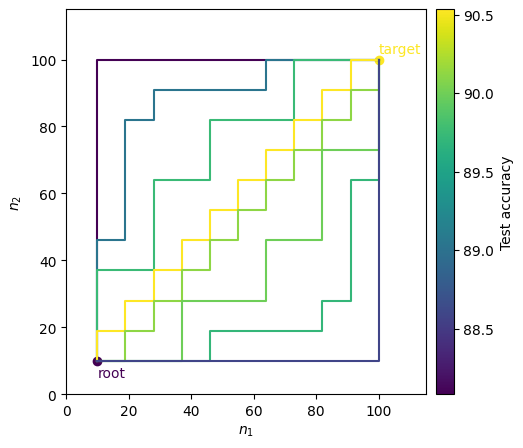

In [43]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, test_acc_root, test_acc_target)

In [65]:
test_accs_1 = test_accs
test_accs_2 = test_accs + 1
test_accs_repeted = [test_accs_1, test_accs_2]

In [66]:
test_accs_repeted

[array([88.08051282, 89.06166667, 89.78397436, 90.535     , 90.13410256,
        90.00371795, 89.71397436, 88.61205128]),
 array([89.08051282, 90.06166667, 90.78397436, 91.535     , 91.13410256,
        91.00371795, 90.71397436, 89.61205128])]

In [81]:
def visualize_statistical_reliability (test_accs_repeted) :
    test_accs_means = np.mean(test_accs_repeted, 0)
    test_accs_stds = np.std(test_accs_repeted, 0)
    
    plt.errorbar(range(1,9), test_accs_means, yerr=test_accs_stds, fmt='o')
    
    plt.show()

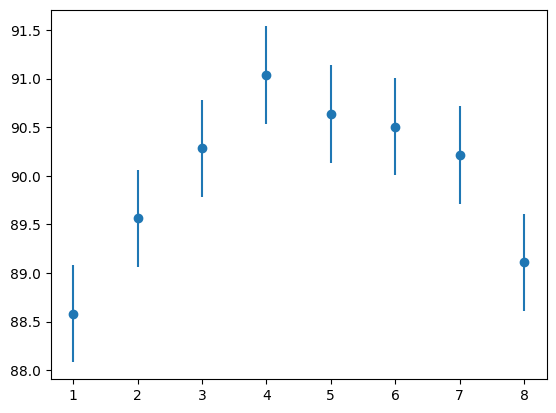

In [82]:
visualize_statistical_reliability (test_accs_repeted)

In [56]:

test_accs = np.array(test_accs)
print("Layer 1 first :", np.mean(test_accs[:4]),
      ". Number of winning paths compared to symetric :",(test_accs[:4]>np.flip(test_accs[4:])).sum())
print("Layer 2 first :", np.mean(test_accs[4:]),
      ". Number of winning paths compared to symetric :",(test_accs[:4]<np.flip(test_accs[4:])).sum())

Layer 1 first : 89.36528846153848 . Number of winning paths compared to symetric : 1
Layer 2 first : 89.61596153846155 . Number of winning paths compared to symetric : 3


In [38]:
def visualize_box_plot(test_accs, test_acc_root, test_acc_target):
    
    test_accs = test_accs+[test_acc_root, test_acc_target]
    
    min_acc, max_acc = min(test_accs), max(test_accs)
    c_scale = cm.viridis(np.linspace(0, 1, 60))

    # Plotting
    fig, ax = plt.subplots(figsize=(2, 5))
    
    plt.boxplot([test_accs], patch_artist=True, widths=0.5, showfliers=False,
                boxprops=dict(facecolor='none'),
                medianprops=dict(color='black'))
    
    xs = np.random.normal(1, 0.04, size=len(test_accs[:-2]))  # Adding jitter for better visibility
    for x, test_acc in zip(xs, test_accs[:-2]) :
        plt.plot(x, test_acc, 'o', markersize=5, c=get_color(c_scale, min_acc, max_acc, test_acc))
    
    plt.plot(1, test_acc_root, 'o', markersize=10, c=get_color(c_scale, min_acc, max_acc, test_acc_root))
    plt.text(1.1, test_acc_root, "root", fontsize=10, color=get_color(c_scale, min_acc, max_acc, test_acc_root))
    plt.plot(1, test_acc_target, 'o', markersize=10, c=get_color(c_scale, min_acc, max_acc, test_acc_target))
    plt.text(1.1, test_acc_target, "target", fontsize=10, color=get_color(c_scale, min_acc, max_acc, test_acc_target))
    

    plt.ylabel('Test accuracies')


    plt.grid(True)
    
    # Create colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Plot Viridis color scale
    cbar = plt.colorbar(cm.ScalarMappable(cmap='viridis', 
                                          norm=plt.Normalize(vmin=min_acc,
                                                             vmax=max_acc)),
                        cax=cax)
    
    plt.show()

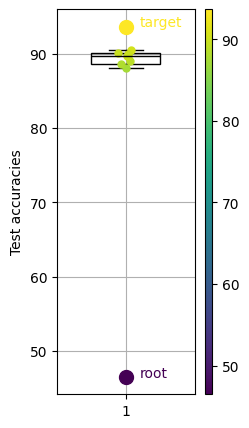

In [39]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target)